In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm, skew
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fare-classification/meta_data.csv
/kaggle/input/ml-dataset/train.csv
/kaggle/input/ml-dataset/test.csv
/kaggle/input/ml-dataset/sample_submission.csv


In [2]:
train = pd.read_csv("../input/ml-dataset/train.csv")
test = pd.read_csv("../input/ml-dataset/test.csv")
IDtest = test["tripid"]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  obj

In [4]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [5]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [6]:
Outliers_to_drop = detect_outliers(train,2,["additional_fare","duration","meter_waiting","meter_waiting_fare","meter_waiting_till_pickup"
                                           ,"pick_lat","pick_lon","drop_lat","drop_lon"])

In [7]:
train.loc[Outliers_to_drop]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
25,189160756,10.5,358.0,66.0,0.0000,79.0,11/1/2019 8:51,11/1/2019 8:57,6.05858,80.2003,6.05566,80.1810,210.58,incorrect
34,189164791,10.5,286.0,44.0,0.0000,9.0,11/1/2019 9:23,11/1/2019 9:28,7.48628,80.6206,7.47984,80.6233,545.89,incorrect
51,189182800,10.5,220.0,10.0,0.0000,27.0,11/1/2019 11:34,11/1/2019 11:37,7.48995,80.3639,7.49838,80.3715,71.84,correct
84,189227008,10.5,2159.0,1158.0,67.5114,344.0,11/1/2019 14:31,11/1/2019 15:07,7.32514,80.6521,7.29959,80.6366,274.56,correct
115,189250944,10.5,1301.0,10.0,0.0000,60.0,11/1/2019 16:43,11/1/2019 17:05,7.31738,80.6995,7.33181,80.6289,356.51,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16751,213125070,10.5,1748.0,80.0,0.0000,37.0,1/29/2020 20:42,1/29/2020 21:11,7.29311,80.6370,7.33452,80.6823,431.96,correct
16944,213372335,10.5,300.0,1.0,0.0583,66.0,1/30/2020 17:48,1/30/2020 17:53,7.30790,80.6371,7.32106,80.6387,99.53,correct
16966,213397557,30.5,777.0,54.0,0.0000,128.0,1/30/2020 18:53,1/30/2020 19:06,7.29334,80.6361,7.32462,80.6355,239.43,correct
17037,213521569,10.5,659.0,40.0,0.0000,87.0,1/31/2020 10:39,1/31/2020 10:50,7.29424,80.6335,7.32501,80.6311,177.47,correct


In [8]:
# train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [9]:
train.shape

(17176, 14)

In [10]:
# train_len = len(train)
# dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [11]:
# dataset = dataset.fillna(np.nan)

# # Check for Null values
# dataset.isnull().sum()

In [12]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  obj

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64

In [13]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [14]:
train.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                         object
dtype: object

In [15]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000


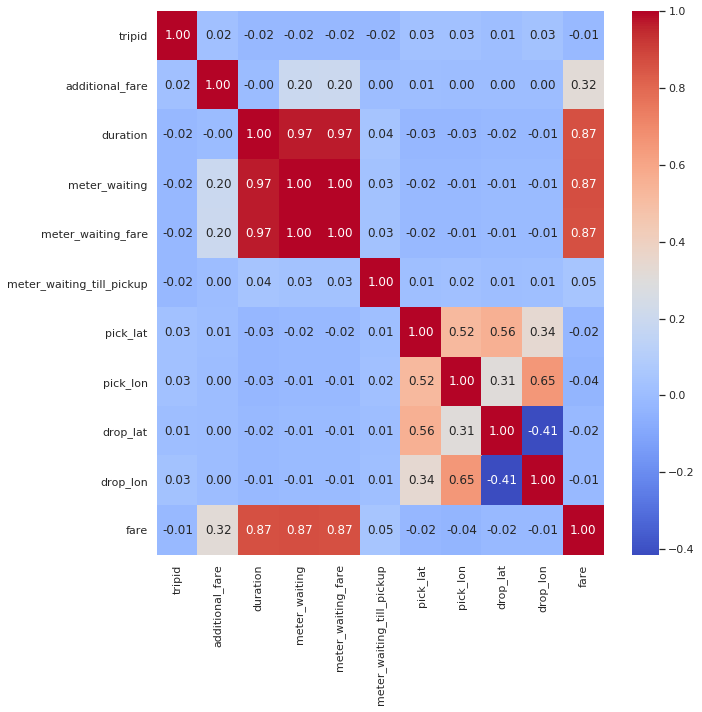

In [16]:
plt.figure(figsize=[10,10])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# Remove Nan

In [17]:
train[( train['meter_waiting'].isnull() & train['meter_waiting_fare'].isnull() 
         & train['additional_fare'].isnull() & train['duration'].isnull() & train['meter_waiting_till_pickup'].isnull() )].shape

(202, 14)

In [18]:
train = train.drop(train[( train['meter_waiting'].isnull() & train['meter_waiting_fare'].isnull() 
         & train['additional_fare'].isnull() & train['duration'].isnull() & train['meter_waiting_till_pickup'].isnull() )].index, axis = 0).reset_index(drop=True)

In [19]:
train[( train['meter_waiting'].isnull() | train['fare'].isnull() )]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
19,189157607,10.5,2956.0,1686.0,97.450800,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,incorrect
29,189164806,10.5,3549.0,2689.0,146.985400,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,incorrect
1909,191263471,5.0,39.0,19.0,1.107700,0.0,11/11/2019 11:00,11/11/2019 11:09,6.93940,79.8756,6.93693,79.8641,NaN,incorrect
2678,192182656,5.0,23.0,23.0,1.340900,0.0,11/15/2019 14:31,11/15/2019 14:35,6.87287,79.8908,6.87959,79.8911,NaN,incorrect
11798,206984071,10.5,1585.0,833.0,48.147400,169.0,1/4/2020 15:05,1/4/2020 15:18,6.91742,79.8550,6.93338,79.8548,NaN,incorrect
13385,209203396,10.5,2423.0,1905.0,110.162896,23.0,1/13/2020 13:03,1/13/2020 13:15,6.91742,79.8550,6.92723,79.8452,NaN,incorrect


In [20]:
train[( train['fare'].isnull() )]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
19,189157607,10.5,2956.0,1686.0,97.450800,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,incorrect
29,189164806,10.5,3549.0,2689.0,146.985400,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,incorrect
1909,191263471,5.0,39.0,19.0,1.107700,0.0,11/11/2019 11:00,11/11/2019 11:09,6.93940,79.8756,6.93693,79.8641,NaN,incorrect
2678,192182656,5.0,23.0,23.0,1.340900,0.0,11/15/2019 14:31,11/15/2019 14:35,6.87287,79.8908,6.87959,79.8911,NaN,incorrect
11798,206984071,10.5,1585.0,833.0,48.147400,169.0,1/4/2020 15:05,1/4/2020 15:18,6.91742,79.8550,6.93338,79.8548,NaN,incorrect
13385,209203396,10.5,2423.0,1905.0,110.162896,23.0,1/13/2020 13:03,1/13/2020 13:15,6.91742,79.8550,6.92723,79.8452,NaN,incorrect


In [21]:
train= train.drop(train[( train['fare'].isnull() )].index, axis = 0).reset_index(drop=True)

In [22]:
train.isnull().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
dtype: int64

# Removing outliers

****Fare****

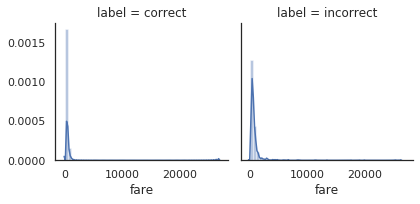

In [23]:
g = sns.FacetGrid(train, col='label')
g = g.map(sns.distplot, "fare")

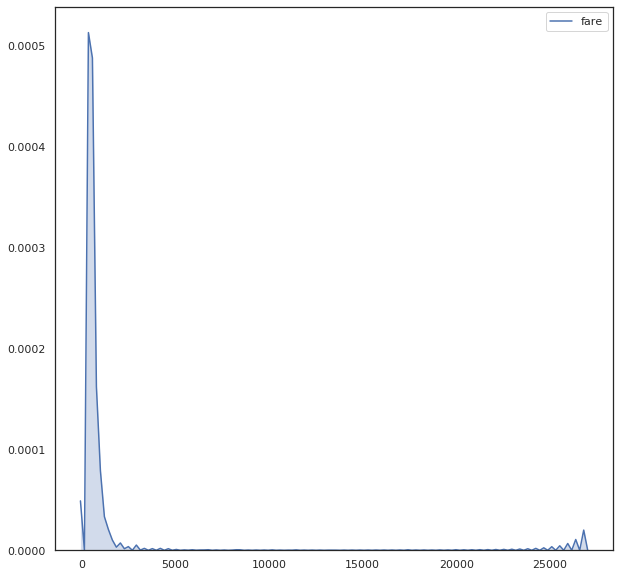

In [24]:
plt.figure(figsize=[10,10])
sns.kdeplot(train['fare'], shade=True);

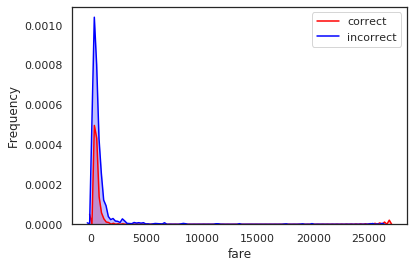

In [25]:
g = sns.kdeplot(train["fare"][(train["label"] == "correct") & (train["fare"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["fare"][(train["label"] == "incorrect") & (train["fare"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("fare")
g.set_ylabel("Frequency")
g = g.legend(["correct","incorrect"])


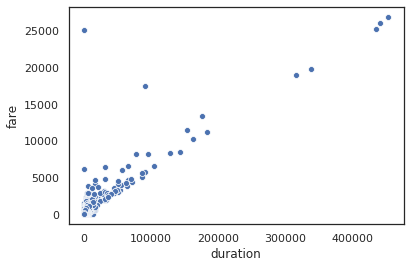

In [26]:
sns.scatterplot(x="duration", y="fare", data=train)

two clear outliers

In [27]:
train[(train['fare']>15000) & (train['duration']<110000)]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
8128,200943864,10.50,91344.0,90026.0,3810.2338,121.0,12/15/2019 14:43,12/16/2019 16:05,6.93729,79.8851,6.94394,79.8980,17499.49,incorrect
13875,209365576,12795.03,40.0,210164.0,12252.5612,182.0,1/16/2020 5:29,1/16/2020 5:29,7.15515,79.8718,7.15537,79.8799,25097.59,incorrect


these two in train set

In [28]:
train = train.drop(train[(train['fare']>15000) & (train['duration']<110000)].index, axis = 0).reset_index(drop=True)

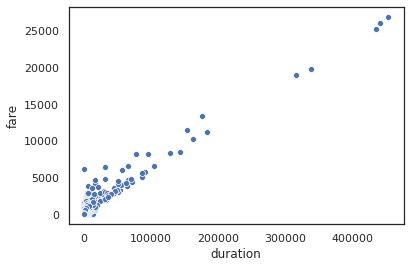

In [29]:
sns.scatterplot(x="duration", y="fare", data=train)

In [30]:
train[(train['fare']>5000) & (train['duration']<1000)]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
11691,206896653,10.5,217.0,54.0,0.0,40.0,1/4/2020 3:09,1/4/2020 3:13,6.91788,79.8485,6.92163,79.8478,6185.32,incorrect


remove or not ?

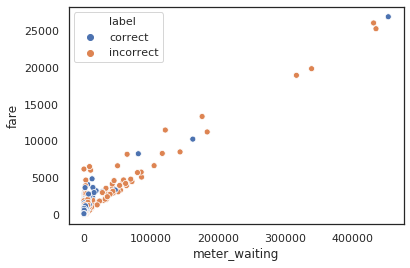

In [31]:
sns.scatterplot(x="meter_waiting", y="fare", hue="label",data=train)

two outlier (it may remove from above)

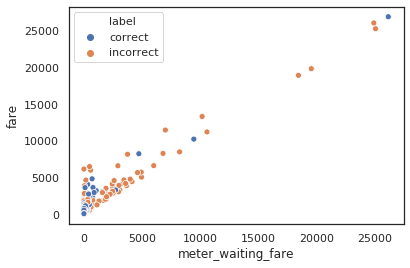

In [32]:
sns.scatterplot(x="meter_waiting_fare", y="fare", hue="label",data=train)

In [33]:
train[(train['fare'] < train['meter_waiting_fare'])]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label


In [34]:
train['fare'].isnull().sum()

0

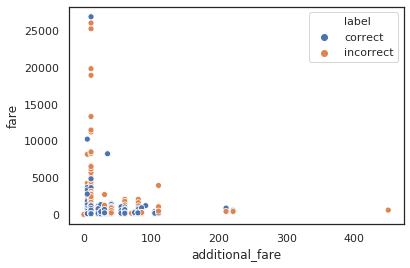

In [35]:
sns.scatterplot(x="additional_fare", y="fare", hue="label",data=train)

In [36]:
train[(train['fare'] < train['additional_fare'])]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
9945,203757140,110.5,521.0,80.0,4.653641,67.0,12/24/2019 17:07,12/24/2019 17:15,7.29295,80.637,7.28589,80.6319,77.51,correct


In [37]:
train = train.drop(train[(train['fare'] < train['additional_fare'])].index, axis = 0).reset_index(drop=True)

In [38]:
train[(train['fare'] < train['additional_fare'] + train['meter_waiting_fare'])]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label


this is test set. meter_waiting is different

**meter_waiting_fare**

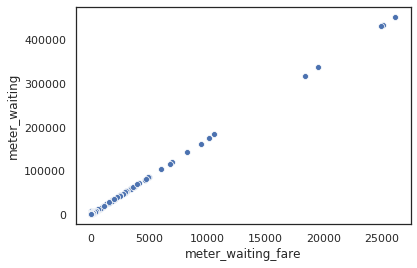

In [39]:
sns.scatterplot(x="meter_waiting_fare", y="meter_waiting",data=train)

fare per time

In [40]:
train[["meter_waiting","meter_waiting_fare"]]

,meter_waiting,meter_waiting_fare
0,56.0,0.0000
1,47.0,0.0000
2,80.0,0.0000
3,271.0,15.6638
4,182.0,0.0000
...,...,...
16960,93.0,5.4219
16961,428.0,0.0000
16962,9.0,0.0000
16963,115.0,0.0000


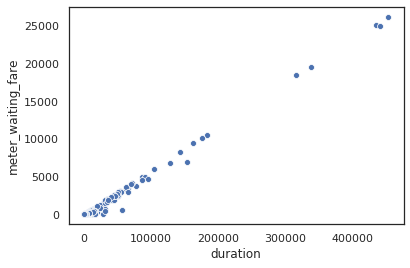

In [41]:
sns.scatterplot(y="meter_waiting_fare", x="duration",data=train)

In [42]:
train[((train['duration'] < 100)   &  (train['meter_waiting_fare'] > 10000))]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label


In [43]:
# dataset["fare"] = dataset["fare"].fillna(dataset["fare"].median())
# dataset["additional_fare"] = dataset["additional_fare"].fillna(dataset["additional_fare"].median())
# dataset["duration"] = dataset["duration"].fillna(dataset["duration"].median())
# dataset["meter_waiting"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
# dataset["meter_waiting_fare"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
# dataset["meter_waiting_till_pickup"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())

In [44]:
# dataset = dataset.fillna(np.nan)

# # Check for Null values
# dataset.isnull().sum()

In [45]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [46]:
dataset.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct


In [47]:
dataset.drop(labels = ["tripid"], axis = 1, inplace = True)

In [48]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [49]:
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     #all_data[feat] += 1
#     dataset[feat] = boxcox1p(dataset[feat], lam)

In [50]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [51]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct


In [52]:
dataset["time"]=(pd.to_datetime(dataset.drop_time)-pd.to_datetime(dataset.pickup_time)).dt.total_seconds()

In [53]:
# dataset["w_time"]=dataset['duration']-dataset['meter_waiting']

In [54]:
len(train)

16965

In [55]:
len(test)

8576

In [56]:
len(dataset)

25541

In [57]:
a=dataset[:len(train)].reset_index(drop=True)

In [58]:
a

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,840.0
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,780.0
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,1080.0
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,600.0
4,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,3420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16960,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct,840.0
16961,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct,2160.0
16962,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct,240.0
16963,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,correct,840.0


In [59]:
# a[a["w_time"]<0]

In [60]:
# train = train.drop(train[train['w_time']<0].index, axis = 0).reset_index(drop=True)

In [61]:
dataset[["drop_time","pickup_time","time"]].head(5)

,drop_time,pickup_time,time
0,11/1/2019 0:34,11/1/2019 0:20,840.0
1,11/1/2019 1:09,11/1/2019 0:56,780.0
2,11/1/2019 1:26,11/1/2019 1:08,1080.0
3,11/1/2019 2:37,11/1/2019 2:27,600.0
4,11/1/2019 6:35,11/1/2019 5:38,3420.0


In [62]:
# dataset['pickup_month'] = pd.to_datetime(dataset.pickup_time).dt.month
# dataset['pickup_day'] = pd.to_datetime(dataset.pickup_time).dt.day
# dataset['pickup_hour'] = pd.to_datetime(dataset.pickup_time).dt.hour
# dataset['pickup_dayofweek'] = pd.to_datetime(dataset.pickup_time).dt.dayofweek
# dataset['pickup_year']=pd.to_datetime(dataset.pickup_time).dt.year
# dataset[["drop_time","pickup_time","pickup_month",'pickup_day','pickup_hour','pickup_dayofweek','pickup_year']]

In [63]:
# g = sns.FacetGrid(dataset, col='pickup_month')
# g = g.map(sns.distplot, "fare")

In [64]:
dataset.drop(labels = ["pickup_time"], axis = 1, inplace = True)
dataset.drop(labels = ["drop_time"], axis = 1, inplace = True)
# dataset.drop(labels = ["time"], axis = 1, inplace = True)

In [65]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,correct,840.0
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,correct,780.0
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,correct,1080.0
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,correct,600.0
4,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,correct,3420.0


In [66]:
dataset.shape

(25541, 12)

In [67]:
dataset[(((dataset['time']-100) < dataset['duration']) &  (dataset['duration'] < (dataset['time']+100)))].shape

(25536, 12)

In [68]:
dataset[(((dataset['time']-100) > dataset['duration']) |  (dataset['duration'] > (dataset['time']+100)))]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time
25,10.5,618.0,128.0,7.3984,126.0,6.88661,79.9321,6.87383,79.9263,106.80,correct,480.0
3519,0.0,0.0,0.0,0.0000,540.0,6.90471,79.8520,6.90457,79.8519,0.00,incorrect,1560.0
14201,10.5,693.0,78.0,0.0000,37.0,6.84484,79.9342,6.83917,79.9087,140.55,correct,540.0
16543,0.0,0.0,0.0,0.0000,973.0,6.85275,79.9391,6.84612,79.9428,0.00,incorrect,1380.0
18700,0.0,0.0,0.0,0.0000,691.0,6.91339,79.8977,6.87683,79.8605,0.00,NaN,2220.0


In [69]:
a=dataset[(((dataset['time']-100) > dataset['duration']) |  (dataset['duration'] > (dataset['time']+100)))].index

In [70]:
a

Int64Index([25, 3519, 14201, 16543, 18700], dtype='int64')

In [71]:
dataset.loc[a]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time
25,10.5,618.0,128.0,7.3984,126.0,6.88661,79.9321,6.87383,79.9263,106.80,correct,480.0
3519,0.0,0.0,0.0,0.0000,540.0,6.90471,79.8520,6.90457,79.8519,0.00,incorrect,1560.0
14201,10.5,693.0,78.0,0.0000,37.0,6.84484,79.9342,6.83917,79.9087,140.55,correct,540.0
16543,0.0,0.0,0.0,0.0000,973.0,6.85275,79.9391,6.84612,79.9428,0.00,incorrect,1380.0
18700,0.0,0.0,0.0,0.0000,691.0,6.91339,79.8977,6.87683,79.8605,0.00,NaN,2220.0


In [72]:
dataset.loc[a,'duration']=dataset.loc[a,'time']

In [73]:
dataset.loc[a]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time
25,10.5,480.0,128.0,7.3984,126.0,6.88661,79.9321,6.87383,79.9263,106.80,correct,480.0
3519,0.0,1560.0,0.0,0.0000,540.0,6.90471,79.8520,6.90457,79.8519,0.00,incorrect,1560.0
14201,10.5,540.0,78.0,0.0000,37.0,6.84484,79.9342,6.83917,79.9087,140.55,correct,540.0
16543,0.0,1380.0,0.0,0.0000,973.0,6.85275,79.9391,6.84612,79.9428,0.00,incorrect,1380.0
18700,0.0,2220.0,0.0,0.0000,691.0,6.91339,79.8977,6.87683,79.8605,0.00,NaN,2220.0


In [74]:
dataset[(((dataset['time']-100) > dataset['duration']) |  (dataset['duration'] > (dataset['time']+100)))]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time


**distance**

In [75]:
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [76]:
dataset['trip_distance']=dataset.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)

In [77]:
# sns.kdeplot(dataset['trip_distance'].values).set_title("Distribution of Trip Distance (log scale)")

In [78]:
dataset['distance']= ((dataset['pick_lat']-dataset['pick_lon'])**2+(dataset['drop_lat']-dataset['drop_lon'])**2)**0.5

In [79]:
# sns.kdeplot(np.log(dataset['distance'].values)).set_title("Distribution of Trip Distance (log scale)")

In [80]:
# sns.scatterplot(x="distance", y="fare",data=dataset)

In [81]:
# sns.scatterplot(x="trip_distance", y="fare",data=dataset)

In [82]:
dataset[dataset['fare']==0].shape

(16, 14)

In [83]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time,trip_distance,distance
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,correct,840.0,3.164501,103.245929
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,correct,780.0,1.968540,103.231285
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,correct,1080.0,3.917991,103.191361
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,correct,600.0,0.535588,103.190511
4,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,correct,3420.0,15.041557,103.031995


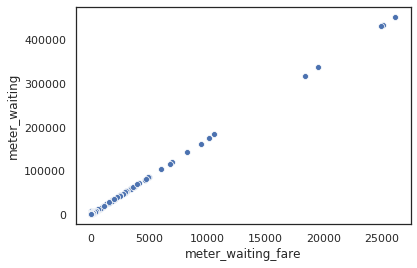

In [84]:
sns.scatterplot(x="meter_waiting_fare", y="meter_waiting",data=train)

In [85]:
b=dataset[((dataset['meter_waiting_fare'] != 0) & (dataset['meter_waiting'] != 0))]

In [86]:
b.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time,trip_distance,distance
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,correct,600.0,0.535588,103.190511
6,10.5,1333.0,295.0,17.1985,212.0,6.90760,79.9524,6.90634,79.9042,318.05,correct,1320.0,3.307275,103.267761
7,10.5,360.0,80.0,4.6640,3.0,7.26706,80.6064,7.27422,80.6124,100.32,correct,360.0,0.643307,103.716669
8,10.5,1539.0,588.0,33.9864,43.0,6.85137,79.9537,6.84779,79.9274,257.89,correct,1560.0,1.821062,103.366242
13,10.5,335.0,10.0,0.5830,17.0,6.85268,79.8631,6.86560,79.8640,126.87,correct,360.0,0.894818,103.243827


In [87]:
b['waiting_fare_per']=b['meter_waiting_fare']/b['meter_waiting']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
b['waiting_fare_per'].head()

3     0.0578
6     0.0583
7     0.0583
8     0.0578
13    0.0583
Name: waiting_fare_per, dtype: float64

In [89]:
b['waiting_fare_per'].mean()

0.05566824898532394

In [90]:
i=dataset[((dataset['meter_waiting_fare'] == 0) & (dataset['meter_waiting'] > 0))].index

In [91]:
dataset.loc[i,'meter_waiting_fare']=dataset.loc[i,'meter_waiting']*b['waiting_fare_per'].mean()

In [92]:
dataset.loc[i]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time,trip_distance,distance
0,10.5,834.0,56.0,3.117422,64.0,6.86252,79.8993,6.90330,79.8783,270.32,correct,840.0,3.164501,103.245929
1,10.5,791.0,47.0,2.616408,134.0,6.88589,79.8984,6.91373,79.8923,197.85,correct,780.0,1.968540,103.231285
2,10.5,1087.0,80.0,4.453460,61.0,6.90839,79.8651,6.93669,79.9146,301.64,correct,1080.0,3.917991,103.191361
4,10.5,3407.0,182.0,10.131621,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,correct,3420.0,15.041557,103.031995
5,10.5,1246.0,487.0,27.110437,133.0,6.84371,79.9051,6.85069,79.8624,266.62,correct,1200.0,2.968678,103.289286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25522,10.5,1206.0,201.0,11.189318,123.0,6.90318,79.8522,6.84278,79.8754,299.74,NaN,1200.0,4.466386,103.224624
25524,10.5,2043.0,74.0,4.119450,44.0,6.86026,79.9063,6.86236,79.9971,430.89,NaN,2040.0,6.230433,103.365440
25528,10.5,1579.0,30.0,1.670047,252.0,6.88485,79.9022,6.93582,79.8957,267.38,NaN,1560.0,3.549796,103.221497
25532,10.5,689.0,6.0,0.334009,80.0,7.15432,79.8719,7.20299,79.8605,268.95,NaN,660.0,3.452385,102.795721


In [93]:
dataset['n_fare']=dataset['fare']- (dataset['additional_fare']-dataset['meter_waiting_fare'])

In [94]:
dataset['n_fare'].describe()

count    25541.000000
mean       324.722063
std        908.135367
min          0.000000
25%        120.066085
50%        208.992351
75%        366.650200
max      53134.091400
Name: n_fare, dtype: float64

In [95]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["label"],axis = 1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [96]:
# train = train.drop(train[train['w_time']<0].index, axis = 0).reset_index(drop=True)

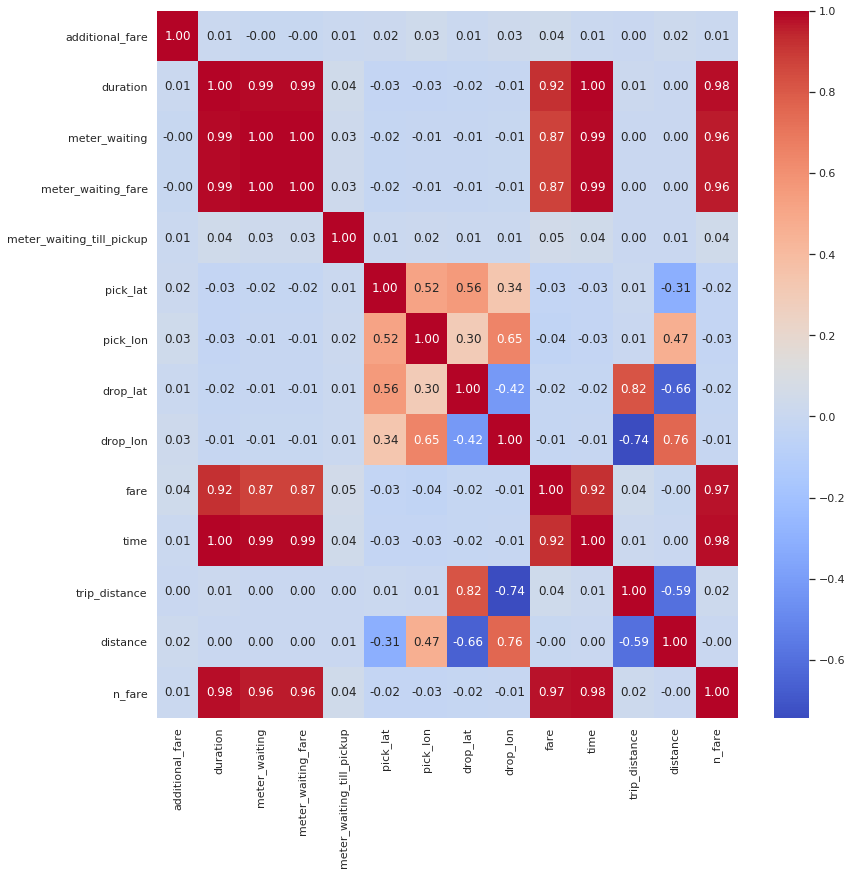

In [97]:
plt.figure(figsize=[13,13])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

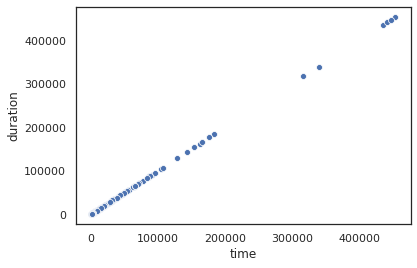

In [98]:
sns.scatterplot(x="time", y="duration",data=dataset)

duration is filled with time 

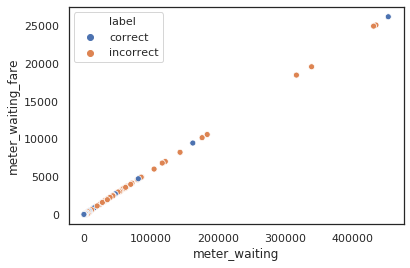

In [99]:
sns.scatterplot(x="meter_waiting", y="meter_waiting_fare",hue="label",data=dataset)

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16965 entries, 0 to 16964
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16965 non-null  float64
 1   duration                   16965 non-null  float64
 2   meter_waiting              16965 non-null  float64
 3   meter_waiting_fare         16965 non-null  float64
 4   meter_waiting_till_pickup  16965 non-null  float64
 5   pick_lat                   16965 non-null  float64
 6   pick_lon                   16965 non-null  float64
 7   drop_lat                   16965 non-null  float64
 8   drop_lon                   16965 non-null  float64
 9   fare                       16965 non-null  float64
 10  label                      16965 non-null  object 
 11  time                       16965 non-null  float64
 12  trip_distance              16965 non-null  float64
 13  distance                   16965 non-null  flo

In [101]:
train["label"] = train["label"].map({"correct": 1, "incorrect":0})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16965 entries, 0 to 16964
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16965 non-null  float64
 1   duration                   16965 non-null  float64
 2   meter_waiting              16965 non-null  float64
 3   meter_waiting_fare         16965 non-null  float64
 4   meter_waiting_till_pickup  16965 non-null  float64
 5   pick_lat                   16965 non-null  float64
 6   pick_lon                   16965 non-null  float64
 7   drop_lat                   16965 non-null  float64
 8   drop_lon                   16965 non-null  float64
 9   fare                       16965 non-null  float64
 10  label                      16965 non-null  int64  
 11  time                       16965 non-null  float64
 12  trip_distance              16965 non-null  float64
 13  distance                   16965 non-null  flo

In [103]:
train.isnull().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
time                         0
trip_distance                0
distance                     0
n_fare                       0
dtype: int64

In [104]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1)

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

In [106]:
train.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,time,trip_distance,distance,n_fare
0,10.5,834.0,56.0,3.117422,64.0,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,3.164501,103.245929,262.937422
1,10.5,791.0,47.0,2.616408,134.0,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,1.968540,103.231285,189.966408
2,10.5,1087.0,80.0,4.453460,61.0,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,3.917991,103.191361,295.593460
3,10.5,598.0,271.0,15.663800,68.0,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.535588,103.190511,87.463800
4,10.5,3407.0,182.0,10.131621,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,1,3420.0,15.041557,103.031995,1064.651621


In [107]:
dataset['additional_fare'].unique()

array([ 10.5 ,   5.  ,  60.5 ,  40.5 ,  35.  ,   0.  ,  55.  , 110.5 ,
       111.  ,  21.  ,  20.5 ,  70.5 ,  11.  ,  80.5 ,  75.  , 105.  ,
       221.  ,  81.  , 450.82,  10.  , 210.5 ,  30.5 ,  25.  ,  91.5 ,
        85.5 ,  80.  ,  61.  , 160.5 ])

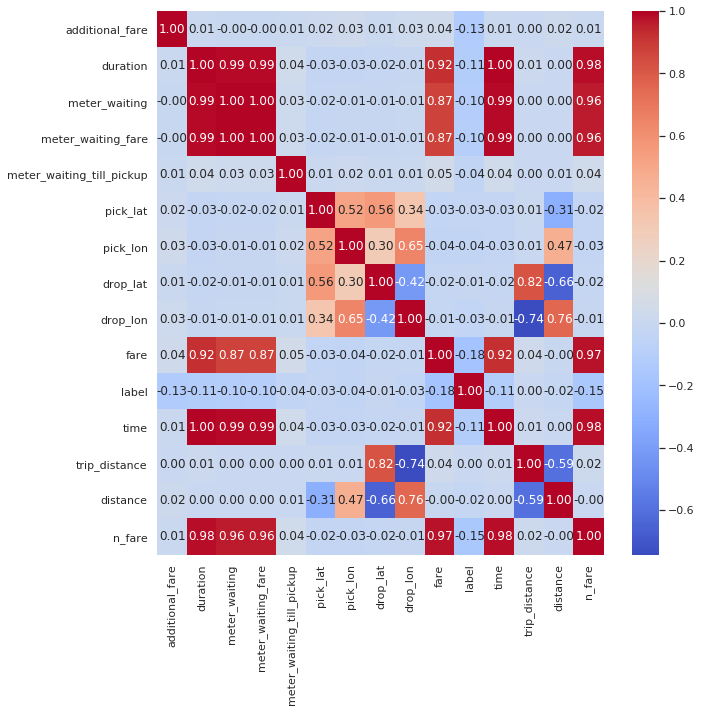

In [108]:
plt.figure(figsize=[10,10])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [109]:
kfold = StratifiedKFold(n_splits=10)

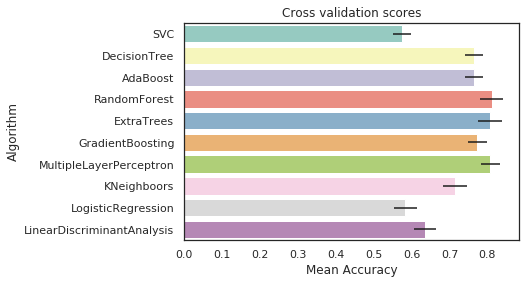

In [110]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "f1_macro", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [111]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.574594,0.024000,SVC
1,0.764047,0.024116,DecisionTree
2,0.764292,0.024000,AdaBoost
3,0.810871,0.029737,RandomForest
4,0.807459,0.031958,ExtraTrees
5,0.773392,0.024339,GradientBoosting
6,0.807781,0.025672,MultipleLayerPerceptron
7,0.715694,0.031675,KNeighboors
8,0.583933,0.030313,LogisticRegression
9,0.634794,0.029599,LinearDiscriminantAnalysis


In [112]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : [ "entropy"],  #"gini",
              "base_estimator__splitter" :   ["best"],  #, "random"],
              "algorithm" : ["SAMME"],   #,"SAMME.R"],
              "n_estimators" :[1],#[2]
              "learning_rate":  [0.0001]}#[ 0.001, 0.01, 0.1, 0.2, 0.3,1.5]

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.3s finished


In [113]:
gsadaDTC.best_score_

0.7549876873760332

In [114]:
gsadaDTC.best_params_

{'algorithm': 'SAMME',
 'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'best',
 'learning_rate': 0.0001,
 'n_estimators': 1}

{'algorithm': 'SAMME',
 'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'best',
 'learning_rate': 0.0001,
 'n_estimators': 1}

In [115]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [10], #1, 3,
              "min_samples_split": [ 10],#2, 3,
              "min_samples_leaf": [1], #3, 10
              "bootstrap": [False],
              "n_estimators" :[100], #,300
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   14.1s finished


0.8256007086022954

0.9452934844949364

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [116]:
gsExtC.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [117]:
gsExtC.best_score_

0.8256007086022954

In [118]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [300], #100,200,
              'learning_rate': [0.1], #0.05, 0.01],
              'max_depth': [8], #4,
              'min_samples_leaf': [100], #150],
              'max_features': [0.3], #0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   54.8s finished


0.8129465512867098

In [119]:
gsGBC.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 0.3,
 'min_samples_leaf': 100,
 'n_estimators': 300}

In [120]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": ["auto"],
              "min_samples_split": [10], #2, 3,
              "min_samples_leaf": [1],# 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100],#300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   43.2s finished


0.8151179824932369

In [121]:
# SVMC = SVC(probability=True)
# svc_param_grid = {'kernel': ['rbf'], 
#                   'gamma': [ 0.001, 0.01, 0.1, 1],
#                   'C': [1, 10, 50, 100,200,300, 1000]}

# gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsSVMC.fit(X_train,Y_train)

# SVMC_best = gsSVMC.best_estimator_

# # Best score
# gsSVMC.best_score_

In [122]:
MLP = MLPClassifier(random_state=random_state)
mlp_param_grid = {
 'activation':['relu'],
 'hidden_layer_sizes':[100],
    'solver': ['adam'],
    'alpha':[0.001],
    'batch_size':["auto"]
}
gsMLP = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 4, verbose = 1)
gsMLP.fit(X_train,Y_train)

gsMLP_best = gsMLP.best_estimator_

# Best score
gsMLP.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   57.6s finished


0.8046465524672808

In [123]:
gsMLP.best_params_

{'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 'auto',
 'hidden_layer_sizes': 100,
 'solver': 'adam'}

In [124]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),('gbc',GBC_best),('mlp',gsMLP_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [125]:
test_Survived = pd.Series(votingC.predict(test), name="prediction")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting_new.csv",index=False)

In [126]:
results.head(50)

,tripid,prediction
0,213284604,1
1,213286352,0
2,213293973,1
3,213294622,1
4,213298687,1
5,213299545,0
6,213302332,1
7,213302671,1
8,213305594,1
9,213305134,1


In [127]:
results['prediction'].value_counts()

1    8210
0     366
Name: prediction, dtype: int64